# Hydrogen Molecule geometry with VQE

This tutorial will show you how to solve an important problem for quantum chemistry using PennyLane on Amazon Braket: finding the ground-state energy of a molecule. The problem can be tackled using near-term quantum hardware by implementing the variational quantum eigensolver (VQE) algorithm. You can find further details on quantum chemistry and VQE in both the [Braket VQE](../../../quantum_algorithms_and_protocols/variational/VQE_Chemistry/VQE_chemistry_braket.ipynb) notebook and PennyLane [tutorials](https://pennylane.ai/qml/demos/tutorial_qubit_rotation.html).

<div class="alert alert-block alert-info">
<b>Note</b> This notebook requires pennylane>=0.18 and amazon-braket-pennylane-plugin>=1.5.0
</div>

## From quantum chemistry to quantum circuits

Our first step is to convert our chemistry problem into something that can be tackled with a quantum computer. To do this, we will use PennyLane's ``qchem`` package. If running on a local machine, the ``qchem`` package must be installed separately by following [these](https://pennylane.readthedocs.io/en/stable/introduction/chemistry.html) instructions.

In [1]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
import time

The input chemistry data is often provided in the form of a geometry file containing details about the molecule. Here, we consider the hydrogen molecule $\mathrm{H}_2$ whose atomic structure is stored in the [h2.xyz](./hydrogen_molecule/h2.xyz) file. The qubit Hamiltonian for $\mathrm{H}_2$ is built using the ``qchem`` package.

In [2]:
symbols, coordinates = qchem.read_structure('hydrogen_molecule/h2.xyz')
h, qubits = qchem.molecular_hamiltonian(symbols, coordinates, name="h2")
print(h)

  (-0.24274280046635355) [Z2]
+ (-0.24274280046635355) [Z3]
+ (-0.04207898539323007) [I0]
+ (0.17771287502652944) [Z0]
+ (0.17771287502652955) [Z1]
+ (0.12293305045330435) [Z0 Z2]
+ (0.12293305045330435) [Z1 Z3]
+ (0.16768319431907505) [Z0 Z3]
+ (0.16768319431907505) [Z1 Z2]
+ (0.17059738365083382) [Z0 Z1]
+ (0.17627640722442822) [Z2 Z3]
+ (-0.0447501438657707) [Y0 Y1 X2 X3]
+ (-0.0447501438657707) [X0 X1 Y2 Y3]
+ (0.0447501438657707) [Y0 X1 X2 Y3]
+ (0.0447501438657707) [X0 Y1 Y2 X3]


In the VQE algorithm, we compute the energy of the $\mathrm{H}_2$ molecule by measuring the expectation value of the above Hamiltonian on a variational quantum circuit. Our objective is to train the parameters of the circuit so that the expectation value of the Hamiltonian is minimized, thereby finding the ground state energy of the molecule.

In this tutorial, we also want to compute the total spin. To that aim, we use the ``qchem`` package to build the total-spin operator $S^2$:

In [3]:
electrons = 2  # Molecular hydrogen has two electrons

S2 = qchem.spin2(electrons, qubits)
print(S2)

  ((0.375+0j)) [Z0]
+ ((0.375+0j)) [Z1]
+ ((0.375+0j)) [Z2]
+ ((0.375+0j)) [Z3]
+ ((0.75+0j)) [I0]
+ ((-0.375+0j)) [Z0 Z1]
+ ((-0.375+0j)) [Z2 Z3]
+ ((-0.125+0j)) [Z0 Z3]
+ ((-0.125+0j)) [Z1 Z2]
+ ((0.125+0j)) [Z0 Z2]
+ ((0.125+0j)) [Z1 Z3]
+ ((-0.125+0j)) [Y0 X1 X2 Y3]
+ ((-0.125+0j)) [X0 Y1 Y2 X3]
+ ((0.125+0j)) [Y0 X1 Y2 X3]
+ ((0.125+0j)) [Y0 Y1 X2 X3]
+ ((0.125+0j)) [Y0 Y1 Y2 Y3]
+ ((0.125+0j)) [X0 X1 X2 X3]
+ ((0.125+0j)) [X0 X1 Y2 Y3]
+ ((0.125+0j)) [X0 Y1 X2 Y3]


## Defining an ansatz circuit

We now set up the ansatz circuit that will be trained to prepare the ground state of the Hamiltonian.

This tutorial uses a chemically-inspired circuit, the [`AllSinglesDoubles`](https://docs.pennylane.ai/en/stable/code/api/pennylane.AllSinglesDoubles.html) ansatz of [Delgado et al. (2020)](https://arxiv.org/abs/2106.13840). To use this, we must define some additional inputs from quantum chemistry.

In [4]:
# Hartree-Fock state
hf_state = qchem.hf_state(electrons, qubits)
# generate single- and double-excitations
singles, doubles = qchem.excitations(electrons, qubits)

<div class="alert alert-block alert-info">
<b>Note</b> A variety of alternative ansätze and templates are <a href="https://pennylane.readthedocs.io/en/stable/introduction/templates.html#quantum-chemistry-templates">available</a> and different choices will result in varying circuit depth and number of trainable parameters.
</div>

Our ansatz circuit is then simple to define:

In [5]:
def circuit(params, wires):
    qml.templates.AllSinglesDoubles(params, wires, hf_state, singles, doubles)

Note that an output measurement has not yet been defined! This is the next step.

## Measuring the energy and total spin

Now we instantiate a device to run our circuits; we will use the Braket local simulator:

In [6]:
dev = qml.device("braket.local.qubit", wires=qubits)

We discussed earlier that we want to minimize the expectation value of the qubit Hamiltonian, corresponding to the energy of $\mathrm{H}_2$. The expectation values of this Hamiltonian and the total spin $\hat{S}^2$ operator can be defined using:

In [7]:
wires = dev.wires.tolist()

@qml.qnode(dev)
def energy_expval(params):
    circuit(params, wires)
    return qml.expval(h)

@qml.qnode(dev)
def S2_expval(params):
    circuit(params, wires)
    return qml.expval(S2)

Notice that `dev` was created without a `shots` argument. This means it will calculate the exact expectation value of the Hamiltonian, and can do so in a single evaluation.

Let's now initialize some random values and evaluate the energy and spin. The total spin $S$ of the prepared state can be obtained from the expectation value $\langle \hat{S}^2 \rangle$ using $S=-\frac{1}{2} + \sqrt{\frac{1}{4} + \langle \hat{S}^2 \rangle}$. We can define a function to compute $S$:

In [8]:
def spin(params):
    return -0.5 + np.sqrt(1 / 4 + S2_expval(params))

In [9]:
np.random.seed(1967)
params = np.random.normal(0, np.pi, len(singles) + len(doubles))

The energy and total spin are then

In [10]:
print("Energy:", energy_expval(params))
print("Spin:  ", spin(params))

Energy: -0.2730496738440533
Spin:   (0.11000908988780544+0j)


Since we have picked random parameters, the measured energy does not correspond to the ground state energy and the prepared state is not an eigenstate of the total-spin operator. We must now train the parameters to find the minimum energy.

## Minimizing the energy

The energy can be minimized by choosing an optimizer and running the standard optimization loop:

In [11]:
# Lets choose RMSPropOptimizer.
# Other alternatives: GradientDescentOptimizer, AdagradOptimizer, AdamOptimizer, ...
opt = qml.RMSPropOptimizer(stepsize=0.2)

In [12]:
iterations = 10

In [13]:
def run_vqe(energy_expval, spin, opt, initial_params, iterations):
    energies = []
    spins = []
    params = initial_params
    
    start = time.time()
    for i in range(iterations):
        params = opt.step(energy_expval, params)
        
        e = energy_expval(params)
        s = spin(params)
        
        energies.append(e)
        spins.append(s)
        
        print(f"Completed iteration {i + 1}")
        print("Energy:", e)
        print("Total spin:", s)
        print("----------------")
            
    print(f"Optimized energy: {e} Ha")
    print(f"Corresponding total spin: {s}")
    print(f"Elapsed: {time.time()-start} s")
    return energies, spins

In [14]:
energies, spins = run_vqe(energy_expval, spin, opt, params, iterations)

Completed iteration 1
Energy: -0.5602851198327653
Total spin: (0.13287789321454424+0j)
----------------
Completed iteration 2
Energy: -0.7773309017117552
Total spin: (0.09488198120584446+0j)
----------------
Completed iteration 3
Energy: -1.0083677187507512
Total spin: (0.04940760029257241+0j)
----------------
Completed iteration 4
Energy: -1.1060574430624097
Total spin: (0.01902625475224662+0j)
----------------
Completed iteration 5
Energy: -1.130111250928373
Total spin: (0.005634781963640423+0j)
----------------
Completed iteration 6
Energy: -1.1351064397745017
Total spin: (0.0012625902560896574+0j)
----------------
Completed iteration 7
Energy: -1.1360215793713093
Total spin: (0.00022566866798257035+0j)
----------------
Completed iteration 8
Energy: -1.1361670884775477
Total spin: (3.2154663963668284e-05+0j)
----------------
Completed iteration 9
Energy: -1.1361867905472756
Total spin: (3.626608394258213e-06+0j)
----------------
Completed iteration 10
Energy: -1.1361890094093072
Tot

The exact value for the ground state energy of molecular hydrogen has been theoretically calculated as ``-1.136189454088`` Hartrees (Ha). Notice that the optimized energy is off by less than $10^{-5}$ of a Hartree. Furthermore, the optimized state is an eigenstate of the total-spin operator with eigenvalue $S=0$ as expected for the ground state of the $\mathrm{H}_2$ molecule. Hence, our above results look very promising! We would get even closer to the theory values if we increase the number of iterations.

Let's visualize how the two quantities evolved during optimization:

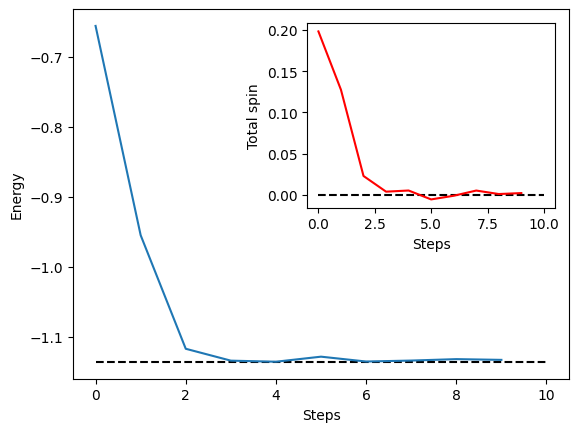

In [40]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

theory_energy = -1.136189454088
theory_spin = 0

plt.hlines(theory_energy, 0, iterations, linestyles="dashed", colors="black")
plt.plot(energies)
plt.xlabel("Steps")
plt.ylabel("Energy")

axs = plt.gca()

inset = inset_axes(axs, width="50%", height="50%", borderpad=1)
inset.hlines(theory_spin, 0, iterations, linestyles="dashed", colors="black")
inset.plot(spins, "r")
inset.set_xlabel("Steps")
inset.set_ylabel("Total spin");

We have learned how to efficiently find the ground state energy of a molecule using the PennyLane/Braket pipeline!

## Running VQE with `shots>0`

In the above example, we computed exact expectation values of our Hamiltonians, and were able to do so with a single evaluation each. This relies on the simulator having access to the exact state, and isn't possible if the device estimates the expectation with shots, like in the case of a QPU.

Suppose we want to estimate the expectation value of the electronic Hamiltonian `h` with a finite number of shots. This Hamiltonian is composed of 15 individual observables that are tensor products of Pauli operators:

In [15]:
print("Number of Pauli terms in h:", len(h.ops))

Number of Pauli terms in h: 15


A straightforward approach to measuring the expectation value would be to run the circuit 15 times, each time measuring one of the Pauli terms that form part of the Hamiltonian `h`. However, we can be more efficient. The Pauli terms can be separated into groups (see PennyLane's [grouping](https://pennylane.readthedocs.io/en/stable/code/qml_grouping.html) module) that share a basis, and thus can be measured concurrently on a single circuit. Elements of each group are known as qubit-wise commuting observables. The Hamiltonian `h` can be split into 5 groups:

In [16]:
groups, coeffs = qml.pauli.group_observables(h.ops, h.coeffs)
print("Number of qubit-wise commuting groups:", len(groups))

Number of qubit-wise commuting groups: 5


Practically, this means that instead of executing 15 separate circuits, we just need to execute 5. This saving can become even more pronounced as the number of Pauli terms in the Hamiltonian increases. For example, switching to a larger molecule or a different chemical basis set can increase both the number of qubits and the number of terms.

Fortunately, the PennyLane/Braket pipeline has builtin support for pre-grouping the observables in a Hamiltonian to minimize the number of device executions, saving both runtime and simulation fees when using remote devices.

<div align="center"><img src="grouping.png"/></div>

To take advantage of grouping, we must instruct PennyLane to break up each Hamiltonian into qubit-wise commuting groups. We do this by computing the groups and storing them with the Hamiltonian; the device will use this information when to create the circuits to run.

In [17]:
h.compute_grouping()
S2.compute_grouping()

Next, we instantiate the device, but this time with nonzero `shots`:

In [18]:
dev = qml.device("braket.local.qubit", wires=qubits, shots=5000)

And redefine our cost functions

In [19]:
wires = dev.wires.tolist()

@qml.qnode(dev)
def energy_expval(params):
    circuit(params, wires)
    return qml.expval(h)

@qml.qnode(dev)
def S2_expval(params):
    circuit(params, wires)
    return qml.expval(S2)

def spin(params):
    return -0.5 + np.sqrt(1 / 4 + S2_expval(params))

Finally, we run the VQE experiment and get our expectation estimates:

In [ ]:
energies, spins = run_vqe(energy_expval, spin, opt, params, iterations)

Completed iteration 1
Energy: -0.5412825955159788
Total spin: (0.15326105042318272+0j)
----------------
Completed iteration 2
Energy: -0.6936120312137185
Total spin: (0.1396092557178953+0j)
----------------
Completed iteration 3
Energy: -0.8906199472713872
Total spin: (0.09703433737097567+0j)
----------------


We see that we get pretty close to the values found through exact calculation! In this experiment, we used the local simulator, but the same steps apply for QPUs, or any simulator that uses a nonzero number of shots!

<div class="alert alert-block alert-info">
<b>What's next?</b> The <code>hydrogen_molecule</code> folder contains additional molecular structure files for different atomic separations of molecular hydrogen. Pick one of the separations and find the ground state energy. How does the ground state energy change with atomic separation? 
</div>